# Notes:

* this Notebook is now modified to match to a smaller maze results
* maze radius is set to be bigger then the far targets in order to reduce collisions
* results is written to MultipleTargets tb log dir in order to keep all logs at the same place

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys


from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.utils import set_random_seed

import matplotlib.pyplot as plt

sys.path.append('..')

import MazeEnv.MultiTargetMazeEnv as mtmz
from MazeEnv.MazeEnv import Rewards
from Utils import make_circular_map, clear_files, get_multi_targets_circle_envs
from Evaluation import EvalAndSaveCallback, MultiTargetEvalAndSaveCallback
import Evaluation

from IPython.display import Image
import ipyplot
import glob

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:

targets = np.genfromtxt("TestTargets/test_coords.csv", delimiter=',')
REWARDS = Rewards(target_arrival=10, collision=-20, timeout=-10, idle=-0.01)


_, eval_env = get_multi_targets_circle_envs(radius=2.7,
                                            targets=targets,
                                            timeout_steps=1000,
                                            rewards=REWARDS,
                                            monitor_dir="logs/FineTuneMultiple/tmp")
                              

# Visual Results
load trained model and show visual results on subset of the targets:

In [10]:
trained_model_dir = os.path.join("logs", "backup_SmallerMaze_5m")
new_results_dir = os.path.join("logs", "FineTuneMultiple")

model = DDPG.load(os.path.join(trained_model_dir, "best_model"))

All videos and gifs already saved.
Uncomment this cell to recreate evaluation videos again.

In [14]:
# N_TARGETS_TO_VISUALIZE = 30

# rewards = []
# reach_target_count = 0

# for tgt in range(N_TARGETS_TO_VISUALIZE):
#     episode_reward = 0
#     done = False
    
#     video_path = os.path.join(new_results_dir, "OldFinal", "final" + str(tgt) + ".avi")
#     print(video_path)
    
#     obs = eval_env.reset(create_video=True, video_path=video_path, target_index=tgt)
#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, done, _ = eval_env.step(action)
#         episode_reward += reward
        
#     rewards.append("reward: " + str(episode_reward))
#     if episode_reward > 0:
#         reach_target_count += 1
    
# _ = eval_env.reset()

# Evaluation.create_gifs_from_avi(os.path.join(new_results_dir, "OldFinal"))

# print("reached target:", reach_target_count)

logs/FineTuneMultiple/OldFinal/final0.avi
logs/FineTuneMultiple/OldFinal/final1.avi
logs/FineTuneMultiple/OldFinal/final2.avi
logs/FineTuneMultiple/OldFinal/final3.avi
logs/FineTuneMultiple/OldFinal/final4.avi
logs/FineTuneMultiple/OldFinal/final5.avi
logs/FineTuneMultiple/OldFinal/final6.avi
logs/FineTuneMultiple/OldFinal/final7.avi
logs/FineTuneMultiple/OldFinal/final8.avi
logs/FineTuneMultiple/OldFinal/final9.avi
logs/FineTuneMultiple/OldFinal/final10.avi
logs/FineTuneMultiple/OldFinal/final11.avi
logs/FineTuneMultiple/OldFinal/final12.avi
logs/FineTuneMultiple/OldFinal/final13.avi
logs/FineTuneMultiple/OldFinal/final14.avi
logs/FineTuneMultiple/OldFinal/final15.avi
logs/FineTuneMultiple/OldFinal/final16.avi
logs/FineTuneMultiple/OldFinal/final17.avi
logs/FineTuneMultiple/OldFinal/final18.avi
logs/FineTuneMultiple/OldFinal/final19.avi
logs/FineTuneMultiple/OldFinal/final20.avi
logs/FineTuneMultiple/OldFinal/final21.avi
logs/FineTuneMultiple/OldFinal/final22.avi
logs/FineTuneMultiple

In [22]:
gifs = glob.glob(os.path.join(new_results_dir, "OldFinal","*.gif"))
gifs.sort()
labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
labels.sort()

ipyplot.plot_images(gifs, labels, rewards, img_width=200)
# ipyplot.plot_images(gifs, labels, img_width=200)

# Keep training

In [35]:
TOTAL_TIME_STEPS = 2_000_000
LEARNING_RATE = 0.2e-7
REDUCE_LR = True
EXPLORATION_NOISE_STD = 0.005

EVAL_FREQ = 40000
VIDEO_FREQ = 5

# should be similar to pretrained model:
REWARDS = Rewards(target_arrival=10, collision=-20, timeout=-10, idle=-0.01)
TIMEOUT_STEPS = 1000 

In [36]:
maze_env, eval_maze_env = get_multi_targets_circle_envs(radius=2.7,
                                                        targets = targets,
                                                        timeout_steps=TIMEOUT_STEPS,
                                                        rewards=REWARDS,
                                                        monitor_dir="logs/FineTuneMultiple/results")
 

# create callback for evaluation
callback = MultiTargetEvalAndSaveCallback(log_dir="logs/FineTuneMultiple",
                                          eval_env=eval_maze_env,
                                          eval_freq=EVAL_FREQ,
                                          eval_video_freq=VIDEO_FREQ,
                                          verbose=1)

def lr_func(progress):
    if progress < 0.5 and REDUCE_LR:
        return LEARNING_RATE/5
    return LEARNING_RATE

exploration_noise = NormalActionNoise(mean=np.array([0]*8), sigma=np.array([EXPLORATION_NOISE_STD]*8))

model = DDPG.load(os.path.join(trained_model_dir, "best_model"), 
                  env=maze_env,
                  custom_objects=dict(tensorboard_log="./logs/MultiTargets/tb",
                                     learning_rate=lr_func,)
                 )

In [37]:
# clear old videos: 
clear_files('logs/FineTuneMultiple/*.gif')
clear_files('logs/FineTuneMultiple/*.avi')

In [38]:
start = time.time()

model.learn(total_timesteps=TOTAL_TIME_STEPS, 
            callback=callback,
            tb_log_name="FT_")

print("time", time.time() - start)

10000 Steps evaluation, avg reward:-11.176999999999989, avg episode length: 285.3666666666667
--Saving new best model--
20000 Steps evaluation, avg reward:-11.584666666666655, avg episode length: 292.8
30000 Steps evaluation, avg reward:-9.478999999999985, avg episode length: 282.23333333333335
--Saving new best model--
40000 Steps evaluation, avg reward:-12.928333333333322, avg episode length: 293.8333333333333
50000 Steps evaluation, avg reward:-10.898666666666653, avg episode length: 290.8666666666667
creating video
60000 Steps evaluation, avg reward:-10.808333333333321, avg episode length: 281.8333333333333
70000 Steps evaluation, avg reward:-12.299333333333323, avg episode length: 297.6
80000 Steps evaluation, avg reward:-12.292999999999987, avg episode length: 296.96666666666664
90000 Steps evaluation, avg reward:-10.885999999999987, avg episode length: 289.6
100000 Steps evaluation, avg reward:-10.138999999999983, avg episode length: 281.56666666666666
creating video
110000 Step

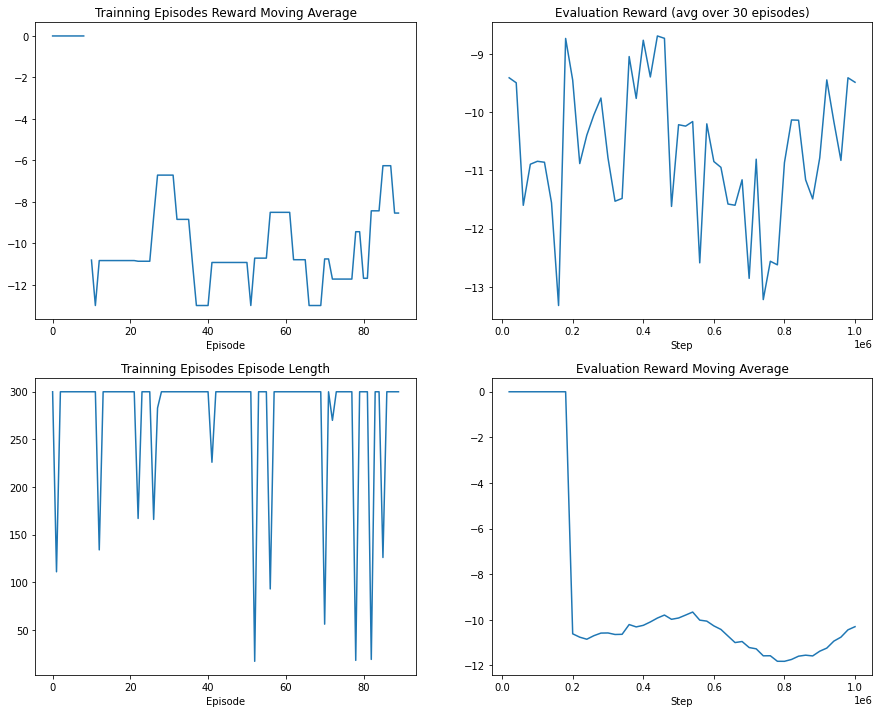

In [3]:
Evaluation.plot_train_eval_results("logs/FineTuneMultiple", 30)

In [40]:
# create gifs and plot them:
Evaluation.create_gifs_from_avi("logs/FineTuneMultiple/")

gifs = glob.glob("logs/FineTuneMultiple/*_steps.gif")
labels = [pth.split('/')[-1].split('.')[0] for pth in gifs]
ipyplot.plot_images(gifs, labels, img_width=200)